In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from custom_layer import *
from image_loader import *
import os
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2
import tensorflow_addons as tfa

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
# 함수형 API로 구성한 Generator의 첫번째 그
def generator_first(input_):
    tensor_list = []
#     input_ = keras.layers.Input(shape=(512, 512, 3),batch_size=3) # (3,512,512,3) 크기의 Input을 생성한다.
    tensor_list.append(input_)
    hidden1 = conv2d_layer_same(16,3,1)(input_)
    tensor_list.append(hidden1)
    act1 = keras.activations.selu(hidden1)
    tensor_list.append(act1)
    bn1 = keras.layers.BatchNormalization()(act1)
    tensor_list.append(bn1)

    hidden2 = conv2d_layer_same(32, 5, 2)(bn1)
    tensor_list.append(hidden2)
    act2 = keras.activations.selu(hidden2)
    tensor_list.append(act2)
    bn2 = keras.layers.BatchNormalization()(act2)
    tensor_list.append(bn2)

    hidden3 = conv2d_layer_same(64, 5, 2)(bn2)
    tensor_list.append(hidden3)
    act3 = keras.activations.selu(hidden3)
    tensor_list.append(act3)
    bn3 = keras.layers.BatchNormalization()(act3)
    tensor_list.append(bn3)

    hidden4 = conv2d_layer_same(128, 5, 2)(bn3)
    tensor_list.append(hidden4)
    act4 = keras.activations.selu(hidden4)
    tensor_list.append(act4)
    bn4 = keras.layers.BatchNormalization()(act4)
    tensor_list.append(bn4)

    hidden5 = conv2d_layer_same(128, 5, 2)(bn4)
    tensor_list.append(hidden5)
    act5 = keras.activations.selu(hidden5)
    tensor_list.append(act5)
    bn5 = keras.layers.BatchNormalization()(act5)

    tensor_list.append(bn5)
    model = keras.Model(inputs=[input_],outputs=bn5)
    return model,tensor_list

def generator_second(input_):
    # 논문 코드의 U-net Generator 두번째 파트에 해당하는 부분
    # 9개의 레이어로 구성되어 있다.
    m1, tensor_list = generator_first(input_)
    input_ = tensor_list[-1]

    hidden1 = conv2d_layer_same(128,5,2)(input_)
    tensor_list.append(hidden1)
    act1 = keras.activations.selu(hidden1)
    tensor_list.append(act1)
    bn1 = keras.layers.BatchNormalization()(act1)
    tensor_list.append(bn1)

    hidden2 = conv2d_layer_same(128, 5, 2)(bn1)
    tensor_list.append(hidden2)
    act2 = keras.activations.selu(hidden2)
    tensor_list.append(act2)
    bn2 = keras.layers.BatchNormalization()(act2)
    tensor_list.append(bn2)

    hidden3 = conv2d_layer_valid(128, 8, 1)(bn2)
    tensor_list.append(hidden3)
    act3 = keras.activations.selu(hidden3)
    tensor_list.append(act3)

    hidden4 = conv2d_layer_valid(128, 1, 1)(act3) # global concat에 사용할 image의 global feature 추출
    tensor_list.append(hidden4)

    # model = keras.Model(inputs=input_,outputs=hidden4)
    return tensor_list

# Unet Generator의 세 번째 레이어 그룹
# global concat과 그냥 concat, residual block 등 다양한 커스텀 레이어를 제작할 필요가 있다.
# 30개의 레이어로 구성되어 있음.

def generator_third(input_):
    tensor_list = generator_second(input_)
    input_ = tensor_list[15] # input index = 15

    # 1번째 conv 그
    hidden1 = conv2d_layer_same(128,3,1)(input_)
    tensor_list.append(hidden1)
    gc1 = exe_global_concat_layer(hidden1, tensor_list, 24)
    tensor_list.append(gc1)

    # 2번째 conv 그룹
    hidden2 = conv2d_layer_same(128,1,1)(gc1)
    tensor_list.append(hidden2)
    act1 = keras.activations.selu(hidden2)
    tensor_list.append(act1)
    bn1 = keras.layers.BatchNormalization()(act1)
    tensor_list.append(bn1)

    # 3번째 conv 그룹
    hidden3 = conv2d_layer_same(128,3,1)(bn1)
    tensor_list.append(hidden3)
    rs1 = exe_resize_layer(hidden3, 2)
    tensor_list.append(rs1)
    #concat_layer index 10
    concat1 = tf.concat([rs1, tensor_list[10]],axis=-1)
    tensor_list.append(concat1)
    act2 = keras.activations.selu(concat1)
    tensor_list.append(act2)
    bn2 = keras.layers.BatchNormalization()(act2)
    tensor_list.append(bn2)

    # 4번째 conv 그룹
    hidden4 = conv2d_layer_same(128, 3, 1)(bn2)
    tensor_list.append(hidden4)
    rs2 = exe_resize_layer(hidden4, 2)
    tensor_list.append(rs2)
    # concat_layer index 7
    concat2 = tf.concat([rs2, tensor_list[7]], axis=-1)
    tensor_list.append(concat2)
    act3 = keras.activations.selu(concat2)
    tensor_list.append(act3)
    bn3 = keras.layers.BatchNormalization()(act3)
    tensor_list.append(bn3)

    # 5번째 Conv 그룹
    hidden5 = conv2d_layer_same(64, 3, 1)(bn3)
    tensor_list.append(hidden5)
    rs3 = exe_resize_layer(hidden5, 2)
    tensor_list.append(rs3)
    # concat_layer index 4
    concat3 = tf.concat([rs3, tensor_list[4]], axis=-1)
    tensor_list.append(concat3)
    act4 = keras.activations.selu(concat3)
    tensor_list.append(act4)
    bn4 = keras.layers.BatchNormalization()(act4)
    tensor_list.append(bn4)

    # 6번째 Conv 그룹
    hidden6 = conv2d_layer_same(32, 3, 1)(bn4)
    tensor_list.append(hidden6)
    rs4 = exe_resize_layer(hidden6, 2)
    tensor_list.append(rs4)
    # concat_layer index 4
    concat4 = tf.concat([rs4, tensor_list[1]], axis=-1)
    tensor_list.append(concat4)
    act5 = keras.activations.selu(concat4)
    tensor_list.append(act5)
    bn5 = keras.layers.BatchNormalization()(act5)
    tensor_list.append(bn5)

    # 7번째 cONV 그룹
    hidden7 = conv2d_layer_same(16,3,1)(bn5)
    tensor_list.append(hidden7)
    act6 = keras.activations.selu(hidden7)
    tensor_list.append(act6)
    bn6 = keras.layers.BatchNormalization()(act6)
    tensor_list.append(bn6)

    # 8번째 conv 그룹
    hidden8 = conv2d_layer_same(3,3,1)(bn6)
    tensor_list.append(hidden8)
    res = exe_res_layer(hidden8,tensor_list,0,[0,1,2])

    model = keras.Model(inputs=tensor_list[0],outputs=res)
    return model, tensor_list


def discriminator(input_):

#     input_ = keras.layers.Input(shape=(512, 512, 3),batch_size=3) # i
    tensor_list = []
    tensor_list.append(input_)

    # hidden 1
    hidden1 = conv2d_layer_same(16,3,1)(input_)
    tensor_list.append(hidden1)
    act1 = keras.layers.LeakyReLU()(hidden1)
    tensor_list.append(act1)
    bn1 = tfa.layers.InstanceNormalization()(act1)
    tensor_list.append(bn1)

    # hidden 2
    hidden2 = conv2d_layer_same(32, 5, 2)(bn1)
    tensor_list.append(hidden2)
    act2 = keras.layers.LeakyReLU()(hidden2)
    tensor_list.append(act2)
    bn2 = tfa.layers.InstanceNormalization()(act2)
    tensor_list.append(bn2)

    # hidden 3
    hidden3 = conv2d_layer_same(64, 5, 2)(bn2)
    tensor_list.append(hidden3)
    act3 = keras.layers.LeakyReLU()(hidden3)
    tensor_list.append(act3)
    bn3 = tfa.layers.InstanceNormalization()(act3)
    tensor_list.append(bn3)

    # hidden 4
    hidden4 = conv2d_layer_same(128, 5, 2)(bn3)
    tensor_list.append(hidden4)
    act4 = keras.layers.LeakyReLU()(hidden4)
    tensor_list.append(act4)
    bn4 = tfa.layers.InstanceNormalization()(act4)
    tensor_list.append(bn4)

    # hidden 5
    hidden5 = conv2d_layer_same(128, 5, 2)(bn4)
    tensor_list.append(hidden5)
    act5 = keras.layers.LeakyReLU()(hidden5)
    tensor_list.append(act5)
    bn5 = tfa.layers.InstanceNormalization()(act5)
    tensor_list.append(bn5)

    # hidden 6
    hidden6 = conv2d_layer_same(128, 5, 2)(bn5)
    tensor_list.append(hidden6)
    act6 = keras.layers.LeakyReLU()(hidden6)
    tensor_list.append(act6)
    bn6 = tfa.layers.InstanceNormalization()(act6)
    tensor_list.append(bn6)

    # hidden 7
    hidden7 = conv2d_layer_valid(1,1,16)(bn6)
    tensor_list.append(hidden7)
    # reduce mean layer, 짧기 때문에 직접 작성하였음
    rml = tf.reduce_mean(hidden7, [1,2,3],keepdims=False) # 파라미터는 순서대로 tensor, axis, keepdims
    tensor_list.append(rml)

    model = keras.Model(inputs=input_, outputs=rml)
    return model, tensor_list

In [3]:
def img_L2_loss(img1, img2):
    return tf.reduce_mean(tf.square(tf.subtract(img1, img2)))

In [4]:
def wasserstein_loss(self, y_true, y_pred):
    return K.mean(y_true * y_pred)

In [5]:
iml = Loader()

raw, clean = iml.load_from_npy_old()

# raw_test = (raw[2103:] - 0.5)
# clean_test = clean[2103:]
raw = raw[:2103]
clean = clean[:2103]

In [6]:
ggen,tl = generator_third(keras.Input((512,512,3),batch_size=3))
rawimg = raw[:3]
fake = ggen(rawimg)

In [7]:
print(np.max(clean[0]))
print(np.max(raw[0]))
print(np.max(fake[0]))

255
213
293.32135


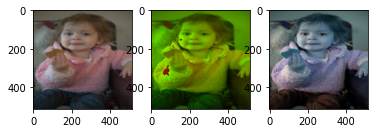

In [8]:
plt.subplot(131)
plt.imshow(raw[1])
plt.subplot(132)
plt.imshow(tf.cast(fake[1],np.uint8))
plt.subplot(133)
plt.imshow(clean[1])
plt.show()

In [9]:
ddisc,tl = discriminator(keras.Input((512,512,3),batch_size=3))
print(ddisc(fake))

tf.Tensor([ 0.0201435  -0.04559292  0.4383705 ], shape=(3,), dtype=float32)


In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=ggen,
                                 discriminator=ddisc)

In [ ]:
def gradient_penalty(self, f, real, fake):
    alpha = random.uniform([self.batch_size, 1, 1, 1], 0., 1.)
    diff = fake - real
    inter = real + (alpha * diff)
    with tf.GradientTape() as t:
        t.watch(inter)
        pred = f(inter)
    grad = t.gradient(pred, [inter])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.)**2)
    return gp

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = img_L2_loss(tf.ones_like(real_output),real_output)
    fake_loss = img_L2_loss(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    return img_L2_loss(tf.ones_like(fake_output), fake_output)

def wgan_grad(raw, raw_test,clean, clean_test):
    return
@tf.function
def train_step(raw,clean,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = ggen(raw)
        
        real_output = ddisc(clean)
        fake_output = ddisc(generated_images)
        
        gen_loss = generator_loss(fake_output)
        
        disc_loss = discriminator_loss(real_output,fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, ggen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, ddisc.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, ggen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, ddisc.trainable_variables))

In [13]:
def train(raw, enhance, epochs):
    for epoch in range(epochs):
        start = time.time()
        for idx in range(0,len(raw),3):
            batch_raw = (raw[idx:idx+3].astype(np.float32) - 127.5) / 127.5
            batch_clean = (clean[idx:idx+3].astype(np.float32) - 127.5) / 127.5
            train_step(batch_raw,batch_clean,epoch)
        display.clear_output(wait=True)
        img_idx = np.random.randint(2103,size=3)
        generate_and_save_images(ggen,epoch+1,raw[img_idx])
        
        if epoch % 10 == 0 and epoch != 0:
            checkpoint.write(file_prefix = checkpoint_prefix)

In [14]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print("max : ",np.max(predictions[0]),"min : ",np.min(predictions[0]))

    plt.imshow(tf.cast(predictions[0],np.uint8))
    plt.savefig('saved_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [15]:
train(raw,clean,100)

KeyboardInterrupt: 